In [4]:
from scipy.integrate import quad, trapz, fixed_quad
import theano
import theano.tensor as T
# from theano.tests.unittest_tools import verify_grad
from theano.compile.ops import as_op

import numpy as np
import pymc3 as pm

import matplotlib.pyplot as plt

import astropy.units as u
from astropy.coordinates import SkyCoord

from tqdm import tqdm

from scipy.ndimage import filters 

from gammapy.spectrum import CountsPredictor, CountsSpectrum
from gammapy.data import DataStore
from gammapy.maps import Map
from gammapy.background import ReflectedRegionsBackgroundEstimator
from gammapy.spectrum import SpectrumObservationList
from gammapy.data import DataStore
from gammapy.spectrum import SpectrumObservationList
from gammapy.maps import Map
from gammapy.background import ReflectedRegionsBackgroundEstimator
from gammapy.spectrum import SpectrumExtraction

from regions import CircleSkyRegion

from utils import load_spectrum_observations, plot_spectra, Log10Parabola, integrate_spectrum, wstat_profile
from forward_fold_model import model_probability, ln_profile_likelihood

%matplotlib inline

In [5]:
import gammapy
gammapy.__version__

'0.9.dev7486'

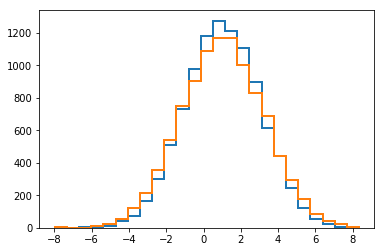

In [6]:
# e = np.append(np.random.normal(loc=0, scale=0.5, size=5000), np.random.normal(loc=2.5, scale=1, size=7500))
e = np.random.normal(loc=1, scale=2, size=10000)
e_predicted = e + np.random.normal(loc=0, scale=0.9, size=len(e))

n_bins = 25
h, bins, _ = plt.hist(e, bins=n_bins, histtype='step', lw=2)
h_pred, _, _ = plt.hist(e_predicted, bins=bins, histtype='step', lw=2)
# h = np.histogram(e, bins=50)
None

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1.])

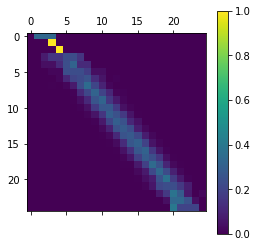

In [7]:
response_matrix, xedges, yedges = np.histogram2d(e_predicted, e, bins=bins)
response_matrix = response_matrix / response_matrix.sum(axis=1)[:, np.newaxis]
# plt.figure(figsize=(10, 10))
plt.matshow(response_matrix)
plt.colorbar()
response_matrix.sum(axis=1)
# None
# m
# repsonse_matrix = 

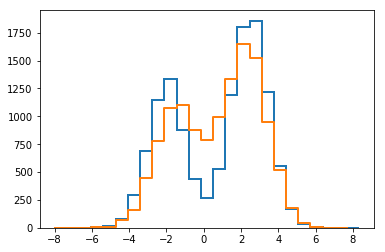

In [8]:
true_data = np.append(np.random.normal(loc=-2, scale=1, size=5000), np.random.normal(loc=2.5, scale=1., size=7500))
true_data_hist, _, _ = plt.hist(true_data, bins=bins, histtype='step', lw=2)
measured_data_hist = true_data_hist @ response_matrix
plt.step(bins[:-1], measured_data_hist , where='post', lw=2)

In [10]:
laplace_matrix = filters.laplace(np.eye(len(true_data_hist))) // 2

laplace_matrix @ true_data_hist, laplace_matrix @ measured_data_hist

(array([   0.,    0.,    3.,   11.,   50.,  150.,  180.,   67., -280.,
        -631.,   10.,  263.,  438.,  402.,  -52., -553., -694.,  -28.,
         272.,  258.,  108.,   21.,    5.,    0.,    0.]),
 array([   0.        ,    0.91076923,    4.04272727,   -1.96746345,
          61.69616282,   19.52586834,  202.77127565,   46.28044504,
         -37.67136363, -271.81203598, -243.78342336,  125.62657774,
         308.20048438,  124.39346023,  -28.90479569, -433.42982811,
        -449.50052251,  149.85615754,   80.40101707,  206.0655631 ,
         105.9030979 ,   21.98163721,    8.09673375,    1.31745545,
           0.        ]))

In [42]:
def response(mu_sig, response_matrix, efficiency=None, fit_range=None,):
    edisp = response_matrix 
    if efficiency:
        edisp *= efficiency[:, np.newaxis]
    counts = T.dot(mu_sig, edisp)
    return counts

def thikonov(f, normalize=False):
    if normalize:
        f = f/f.sum()
    a = T.dot(laplace_matrix, f)
    a_transposed = a.T 
    return 0.5*T.dot(a, a_transposed)

def thikonov_np(g, normalize=False):
    if normalize:
        g = g/len(g)
    a = np.dot(laplace_matrix, g)
    a_transposed = a.T 
    return 0.5* np.dot(a, a_transposed)

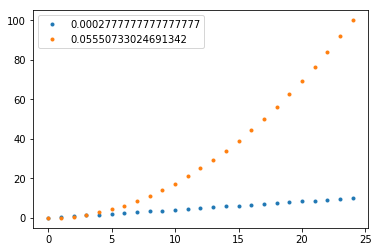

In [44]:
f = np.linspace(0, 10, len(true_data_hist))
plt.plot(f, '.',  label=thikonov_np(f, normalize=True))

f = np.linspace(0, 10, len(true_data_hist))**2
plt.plot(f,  '.', label=thikonov_np(f, normalize=True),)

plt.legend()

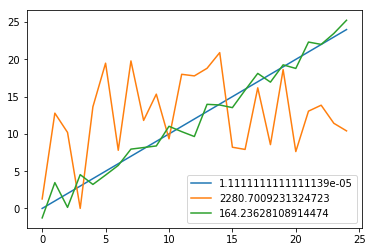

In [16]:
f = np.arange(25)
plt.plot(f, label=thikonov_np(f, normalize=True))

f = np.random.uniform(low=0, high=25, size=25)
plt.plot(f, label=thikonov_np(f))


f = np.arange(25) + np.random.normal(loc=0, scale=1, size=25)
plt.plot(f, label=thikonov_np(f))

plt.legend()

0.0023687760538024837


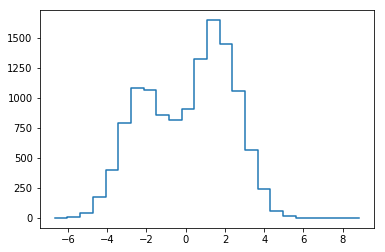

In [359]:
plt.step(bins[:-1], measured_data_hist)
print(thikonov_np(measured_data_hist))

In [438]:
tau = 0.01

model = pm.Model(theano_config={'compute_test_value': 'ignore'})
with model:
    mu_s = pm.Uniform('mu_s', shape=len(true_data_hist), upper=20000, lower=0)
#     tau = pm.HalfNormal('tau', sd=10)
    expected_counts = response(mu_s, response_matrix)
#     lam = thikonov(mu_s, normalize=True)
#     pm.Deterministic('lam', lam)
    
    lam = pm.math.log(thikonov(mu_s, normalize=False))
    pm.Deterministic('lam', lam)
    
    logp = pm.Normal.dist(mu=0, sd=1/tau).logp(lam) 
    

    ll = pm.Deterministic('logp', logp)
    p = pm.Potential("thikonov", logp)
    

    
    s = pm.Poisson('signal', mu=expected_counts, observed=measured_data_hist)

In [439]:
model.test_point, 

({'mu_s_interval__': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.])},)

In [440]:
with model:
#     step1 = pm.Metropolis()
#     trace = pm.sample(10, step=step1, chains=1, cores=1, tune=0, progressbar=False)
#     trace = pm.sample(100, chains=1, cores=1, init='auto', target_accept=0.9, tune=100, progressbar=False)
    trace = pm.sample(1500, chains=5, cores=5, init='auto', target_accept=0.9, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [mu_s]
Sampling 5 chains: 100%|██████████| 12500/12500 [00:27<00:00, 451.43draws/s]
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f06d65ae780>,
      dtype=object)

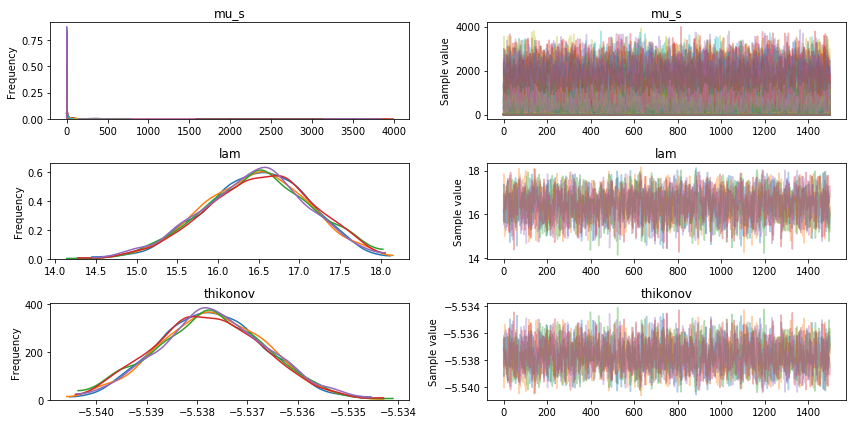

In [441]:
pm.traceplot(trace)

In [442]:
# if 'epsilon' in trace.varnames:
#     plt.matshow(trace['epsilon'].mean(axis=0))
#     plt.title('epsilon')
#     plt.colorbar()

#     plt.figure()
#     plt.matshow(response_matrix)
#     plt.title('edisp')
#     plt.colorbar()
    
#     plt.figure()
#     m  = response_matrix / trace['epsilon'].mean(axis=0)
#     plt.matshow(m)
#     plt.title('epsilon + edisp')
#     plt.colorbar()

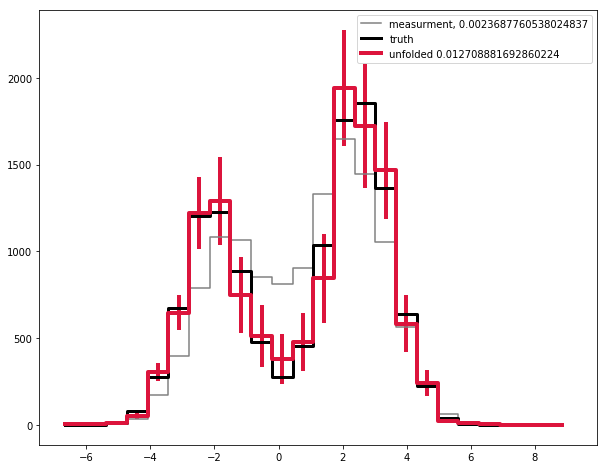

In [443]:
unfolded =  trace['mu_s'].mean(axis=0)
plt.figure(figsize=(10, 8))
plt.step(bins[:-1], measured_data_hist, where='post', label=f'measurment, {thikonov_np(mu_s=measured_data_hist,)}', color='gray')
plt.step(bins[:-1], true_data_hist, where='post', label='truth', lw=3, color='k')
plt.step(bins[:-1], unfolded, where='post', label=f'unfolded {thikonov_np(mu_s=unfolded)}', lw=4, color='crimson')

bin_widths = np.diff(bins)

std = trace['mu_s'].std(axis=0)
plt.errorbar(bins[:-1] + bin_widths/2, unfolded, yerr=std/2, color='crimson', lw=4, linestyle='None')
# plt.step(bins[:-1], unfolded @ response_matrix, where='post', label='unfolded then folded')

plt.legend()

In [ ]:
from scipy.special import kl_div
kl = kl_div(true_data_hist, unfolded)
plt.step(bins[:-1], kl, where='post', label='kl')
kl.sum()

In [336]:
with model:
    samples = pm.sample_ppc(trace)

100%|██████████| 1500/1500 [00:00<00:00, 1904.80it/s]


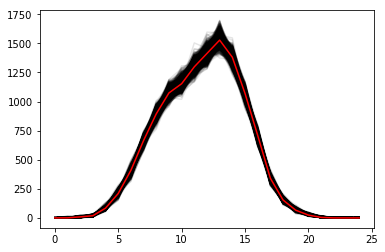

In [337]:
plt.figure()
plt.plot(samples['signal'].T, color='k', alpha=0.1)
plt.plot(measured_data_hist , color='red')

# plt.figure()
# plt.plot(samples['background'].T, color='k', alpha=0.1)
# plt.plot(off_data, color='red')

None

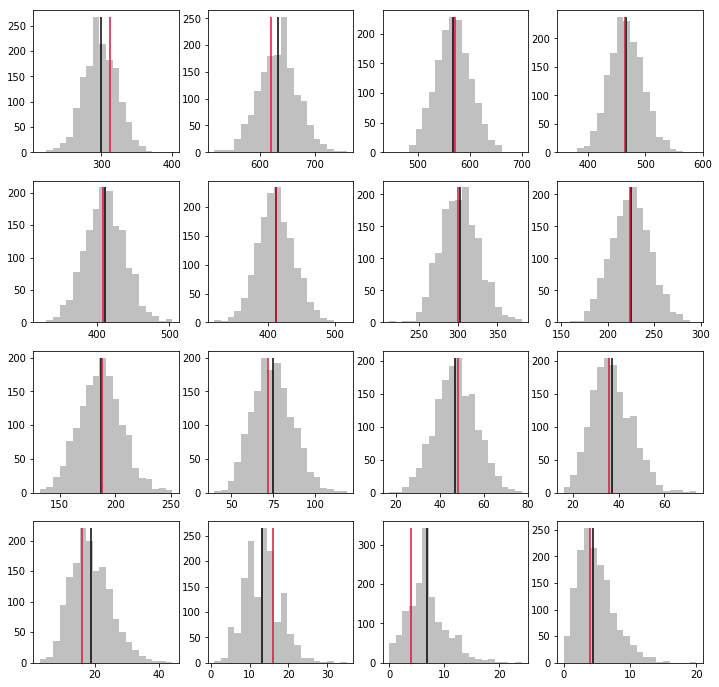

In [612]:
fig, axs = plt.subplots(4, 4, figsize=(12, 12))
for s, signal, ax in zip(samples['signal'].T, on_data, axs.ravel()):
    h, _,_ =  ax.hist(s, bins=20, lw=2, color='silver')
    ax.vlines(s.mean(), ymin=0, ymax=h.max())
    ax.vlines(signal, ymin=0, ymax=h.max(), color='crimson')
    

In [602]:
# display the total number and percentage of divergent
divergent = trace['diverging']
print('Number of Divergent %d' % divergent.nonzero()[0].size)
divperc = divergent.nonzero()[0].size / len(trace) * 100
print('Percentage of Divergent %.1f' % divperc)

Number of Divergent 21
Percentage of Divergent 1.4


In [562]:
pm.summary(trace).round(3)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu_b__0,725.150,27.575,0.798,674.062,780.005,419.787,1.008
mu_b__1,1779.906,41.867,0.724,1699.332,1863.320,3011.589,1.001
mu_b__2,1762.302,41.375,0.910,1685.158,1847.235,1848.776,1.002
mu_b__3,1464.219,37.956,1.083,1390.536,1538.045,643.472,1.002
mu_b__4,1068.069,32.858,1.022,1004.702,1130.363,562.080,1.002
mu_b__5,803.915,28.266,0.890,751.225,860.786,459.367,1.009
mu_b__6,595.212,24.365,0.516,550.831,645.758,1768.937,1.002
mu_b__7,339.486,18.280,0.423,303.812,377.000,1653.846,1.001
mu_b__8,331.840,17.254,0.329,297.723,365.392,3006.954,1.000
mu_b__9,211.918,14.659,0.594,184.081,241.745,216.504,1.011
